# ExoNAMD API v1.0


## Summary

The observer wants to compute the relative and/or absolute NAMD of:

- a given multiplanetary system;
- a subset of multiplanetary systems;
- all the known ones.

This tool handles all of the above cases.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import numpy as np
import pandas as pd
import swifter
import warnings
from loguru import logger

from exonamd.catalog import download_nasa_confirmed_planets
from exonamd.utils import ROOT
from exonamd.utils import fetch_aliases
from exonamd.utils import update_host
from exonamd.utils import update_planet
from exonamd.utils import check_name
from exonamd.solve import solve_values
from exonamd.interp import interp_eccentricity
from exonamd.interp import interp_mass
from exonamd.interp import interp_inclination
from exonamd.interp import interp_sma
from exonamd.solve import solve_relincl
from exonamd.interp import interp_trueobliq
from exonamd.utils import groupby_apply_merge
from exonamd.solve import solve_namd
from exonamd.solve import solve_namd_mc
from exonamd.plot import simple_plot
from exonamd.plot import pop_plot


warnings.filterwarnings("ignore")
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

### Task 1: getting the data

This task retrieves the parameters of confirmed systems from the NASA Exoplanet Archive database.


In [ ]:
df, df_old = download_nasa_confirmed_planets(
    sy_pnum=1,
    from_scratch=True,
)

### Task 2: dealing with the aliases


Fetch aliases


In [ ]:
aliases = fetch_aliases(df["hostname"].unique())

Curate aliases


In [ ]:
logger.info("Updating host and planet names")
df["hostname"] = df.swifter.apply(update_host, args=(aliases,), axis=1)
df["pl_name"] = df.swifter.apply(update_planet, args=(aliases,), axis=1)
logger.info("Names updated")

Check consistency of planet names


In [ ]:
logger.info("Checking consistency of planet names")
name_ok = df.groupby("hostname")["pl_name"].apply(check_name)

for hostname in name_ok[~name_ok].index:
    logger.error(f"Inconsistent planet names for {hostname}")
logger.info("Consistency check done")

### Task 3: computing missing values (if any) from simple equations


In [ ]:
logger.info("Computing missing values from simple relations")
df[
    [
        "pl_orbsmax",
        "pl_ratdor",
        "st_rad",
        "pl_rade",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ]
] = df.swifter.apply(solve_values, axis=1)
logger.info("Missing values computed")

Drop columns that are no longer needed


In [ ]:
logger.debug("Dropping columns that are no longer needed")
df.drop(
    columns=[
        "pl_ratdor",
        "st_rad",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ],
    inplace=True,
)
logger.debug("Columns dropped")

### Task 4: storing the curated database


In [ ]:
logger.info("Storing the curated database")
if df_old is not None:
    df = pd.concat([df.copy(), df_old], ignore_index=True)
    df = df.drop_duplicates(keep="last")
    df.reset_index(drop=True)

out_path = os.path.join(ROOT, "data", "exo.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

In [ ]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo.csv"))

### Task 5: input missing values (if any) by interpolation


Use nanmedian to thin down the data


In [ ]:
logger.info("Thinning down the data with nanmedian")

cols = df.columns.difference(["hostname", "pl_name", "default_flag", "rowupdate"])
medians = df.groupby("pl_name")[cols].transform(np.nanmedian)
df.loc[df["default_flag"] == 1, cols] = medians.loc[df["default_flag"] == 1]
df = df[df["default_flag"] == 1].drop(columns="default_flag")

logger.info("Data thinned down")

Check presence of duplicates (if any)


In [ ]:
logger.info("Checking for duplicates")
dp = df[df.duplicated(subset=["hostname", "pl_name"], keep=False)].sort_values(
    by=["hostname", "pl_name"]
)

if len(dp) > 0:
    logger.error(f"Duplicated rows for {dp['hostname'].unique()}")
    raise ValueError(f"Duplicated rows for {dp['hostname'].unique()}")
logger.info("No duplicates found")

Instantiate flags


In [ ]:
logger.info("Instantiating the flags")
df["flag"] = "0"
logger.info("Flags instantiated")

Solve missing eccentricity values


In [ ]:
logger.info("Interpolating missing eccentricity values")
df[
    [
        "pl_orbeccen",
        "pl_orbeccenerr1",
        "pl_orbeccenerr2",
        "flag",
    ]
] = df.swifter.apply(interp_eccentricity, axis=1)
logger.info("Values interpolated")

Solve missing planetary mass values


In [ ]:
logger.info("Interpolating missing planetary mass values")
df[
    [
        "pl_bmasse",
        "pl_bmasseerr1",
        "pl_bmasseerr2",
        "flag",
    ]
] = df.swifter.apply(interp_mass, axis=1)
logger.info("Values interpolated")

Drop columns that are no longer needed


In [ ]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"], inplace=True)
logger.debug("Columns dropped")

Remove systems where at least one planet has no mass or semi-major axis (if any)


In [ ]:
logger.info("Removing systems where at least one planet has no mass or semi-major axis")
mask = (
    df.groupby("hostname")[["pl_bmasse", "pl_orbsmax"]]
    .transform(lambda x: x.isnull().any())
    .any(axis=1)
)
rm_systems = df[mask]["hostname"].unique()
logger.info(f"Removing {len(rm_systems)} systems: {rm_systems}")
df = df[~mask]
logger.info("Systems removed")

Solve missing values in inclinations


In [ ]:
logger.info("Interpolating missing values in inclinations")
df[
    [
        "pl_orbincl",
        "pl_orbinclerr1",
        "pl_orbinclerr2",
        "flag",
    ]
] = df.swifter.apply(interp_inclination, args=(df,), axis=1)
logger.info("Values interpolated")

Interpolate missing values in semi-major axis uncertainties


In [ ]:
logger.info("Interpolating missing values in semi-major axis uncertainties")
df[
    [
        "pl_orbsmaxerr1",
        "pl_orbsmaxerr2",
        "flag",
    ]
] = df.swifter.apply(interp_sma, axis=1)
logger.info("Values interpolated")

### Task 6: compute the parameters for the NAMD calculation


Compute the relative inclination


In [ ]:
logger.info("Computing the relative inclinations")
df[
    [
        "pl_relincl",
        "pl_relinclerr1",
        "pl_relinclerr2",
    ]
] = df.swifter.apply(solve_relincl, args=(df,), axis=1)
logger.info("Values computed")

Interpolate missing values in true obliquity


In [ ]:
logger.info("Interpolating missing values in true obliquity")
df[
    [
        "pl_trueobliq",
        "pl_trueobliqerr1",
        "pl_trueobliqerr2",
        "flag",
    ]
] = df.swifter.apply(interp_trueobliq, args=(df,), axis=1)
logger.info("Values interpolated")

### Task 7: storing the curated+interpolated database


In [ ]:
logger.info("Storing the curated+interpolated database")
out_path = os.path.join(ROOT, "data", "exo_interp.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

In [96]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_interp.csv"))

### Task 8: computing the NAMD


Drop columns that are no longer needed

In [97]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2"], inplace=True)
logger.debug("Columns dropped")

2024-08-19 13:41:21.841 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-08-19 13:41:21.843 | DEBUG    | __main__:<module>:3 - Columns dropped


Solve the relative and absolute namd


In [98]:
logger.info("Computing the relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="rel",
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-08-19 13:41:22.468 | INFO     | __main__:<module>:1 - Computing the relative NAMD
2024-08-19 13:41:24.189 | INFO     | __main__:<module>:9 - Relative NAMD computed


In [99]:
logger.info("Computing the absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="abs",
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-08-19 13:41:28.159 | INFO     | __main__:<module>:1 - Computing the absolute NAMD
2024-08-19 13:41:30.009 | INFO     | __main__:<module>:9 - Absolute NAMD computed


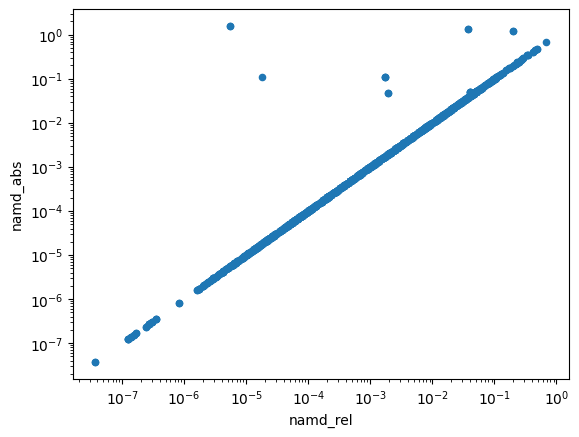

In [100]:
_ = (
    df.groupby("hostname")[["namd_rel", "namd_abs"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel", y="namd_abs", loglog=True)
)

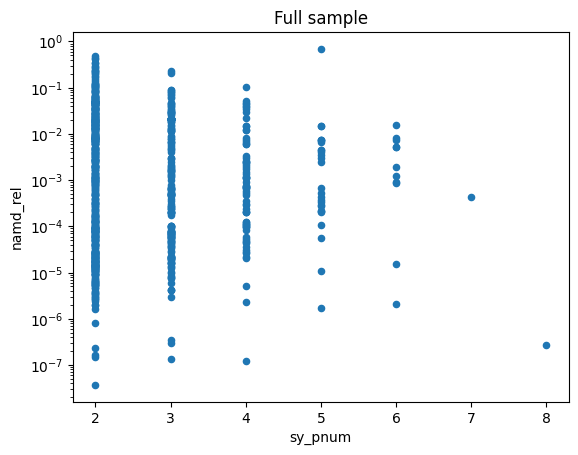

In [101]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Full sample")
)

Core sample


In [102]:
logger.info("Defining the core sample")
core_flags = ["0", "05+", "05-", "05+-"]
df_core = df.groupby("hostname").filter(lambda x: all(x["flag"].isin(core_flags)))
logger.info("Core sample defined")

2024-08-19 13:42:52.694 | INFO     | __main__:<module>:1 - Defining the core sample
2024-08-19 13:42:53.131 | INFO     | __main__:<module>:4 - Core sample defined


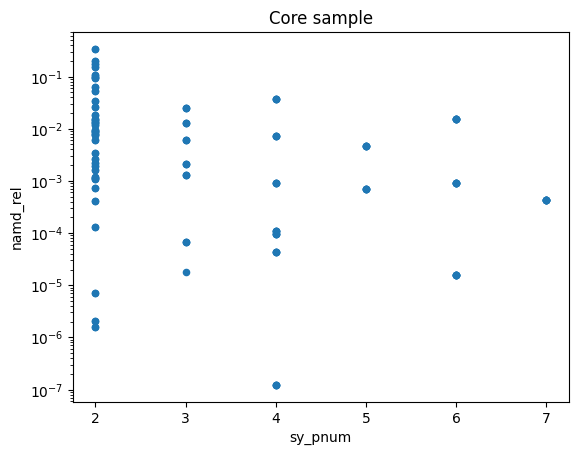

In [103]:
_ = (
    df_core.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .transform("mean")
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Core sample")
)

### Task 9: computing the NAMD and associated confidence intervals


In [104]:
Npt = 200000
threshold = 100

In [105]:
logger.info("Computing the Monte Carlo relative NAMD")
df_core = groupby_apply_merge(
    df_core,
    "hostname",
    solve_namd_mc,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-08-19 13:43:57.332 | INFO     | __main__:<module>:1 - Computing the Monte Carlo relative NAMD
2024-08-19 13:44:04.118 | INFO     | __main__:<module>:11 - Relative NAMD computed


In [106]:
logger.info("Computing the Monte Carlo absolute NAMD")
df_core = groupby_apply_merge(
    df_core,
    "hostname",
    solve_namd_mc,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-08-19 13:44:29.082 | INFO     | __main__:<module>:1 - Computing the Monte Carlo absolute NAMD
2024-08-19 13:44:35.862 | INFO     | __main__:<module>:11 - Absolute NAMD computed


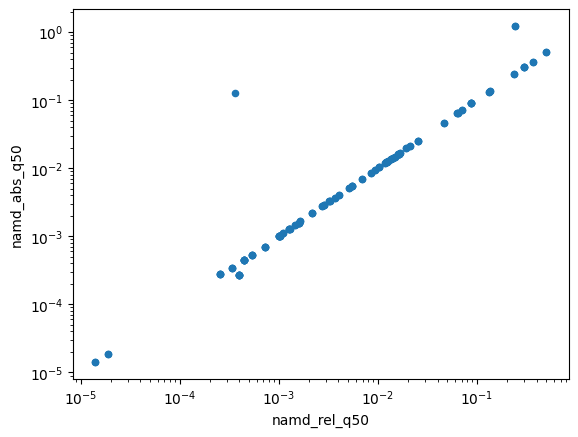

In [107]:
_ = (
    df_core.groupby("hostname")[["namd_rel_q50", "namd_abs_q50"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel_q50", y="namd_abs_q50", loglog=True)
)

In [108]:
logger.info("Storing the NAMD database")
out_path = os.path.join(ROOT, "data", "exo_namd.csv")
df_core.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-08-19 13:45:06.750 | INFO     | __main__:<module>:1 - Storing the NAMD database
2024-08-19 13:45:06.762 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/data/andrea.bocchieri/.conda/envs/exonamd/lib/python3.10/site-packages/exonamd/data/exo_namd.csv


In [109]:
df_core = pd.read_csv(os.path.join(ROOT, "data", "exo_namd.csv"))

### Some plots


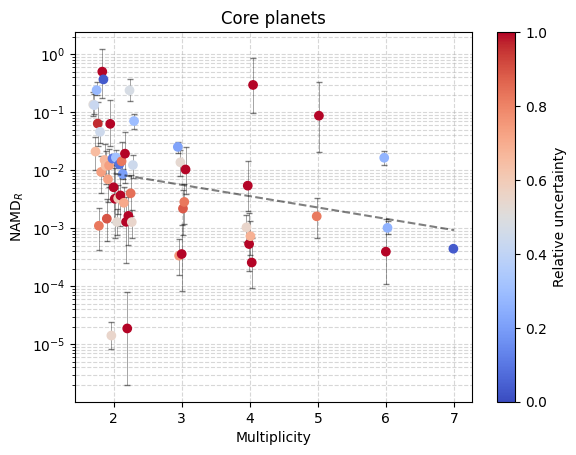

In [110]:
pop_plot(
    df=df_core.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
        include_groups=False,
    ),
    kind="rel",
    title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)

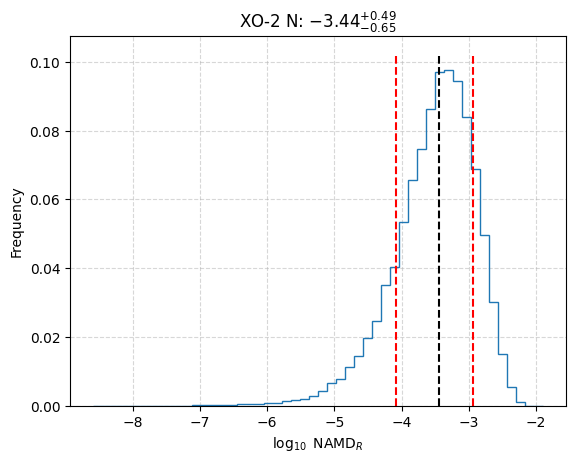

In [111]:
hostname = "XO-2 N"
host = df_core[df_core["hostname"] == hostname]

retval = solve_namd_mc(
    host=host,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    full=True,
)

simple_plot(
    df=retval,
    kind="rel",
    title=hostname,
    which="namd",
    scale="log",
)

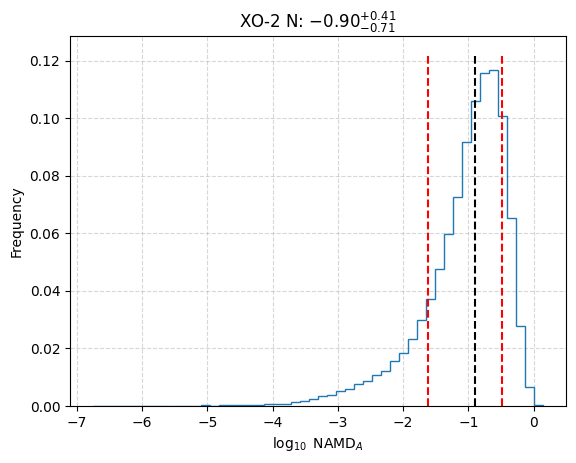

In [112]:
retval = solve_namd_mc(
    host=host,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    full=True,
)

simple_plot(
    df=retval,
    kind="abs",
    title=hostname,
    which="namd",
    scale="log",
)